<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/DTree_and_RForest_w_skleanr%26xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Decision Trees and Random Forests**

Course: [Machine Learning with Python: Zero to GBMs](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/lesson/decision-trees-and-hyperparameters)

In this assignment, I'll build on the previous assignment to predict the price of a house using information like its location, area, no. of rooms etc. The dataset from the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition on `Kaggle`.

Step-by-step process:

1. Download and prepare the dataset for training
2. Train, evaluate and interpret a decision tree
3. Train, evaluate and interpret a random forest
4. Tune hyperparameters to improve the model
5. Make predictions and save the model

### Downloading Dataset

In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install scikit-learn --upgrade --quiet
!pip install xgboost --upgrade --quiet

In [ ]:
import os
from zipfile import ZipFile
from urllib.request import urlretrieve
import sklearn
sklearn.__version__

'0.24.2'

Using `datasets` libraries to download dataset from Kaggle

In [ ]:
dataset_url = 'https://github.com/JovianML/opendatasets/raw/master/data/house-prices-advanced-regression-techniques.zip'
urlretrieve(dataset_url, 'house-prices.zip')
with ZipFile('house-prices.zip') as f:
    f.extractall(path='house-prices')
    
os.listdir('house-prices')

['data_description.txt', 'sample_submission.csv', 'train.csv', 'test.csv']

  Create dataframe for `train dataset` and `test dataset`. Note: `test_dataset` does not have SalePrice column

In [ ]:
import pandas as pd 

In [ ]:
train_dataset = pd.read_csv('house-prices/train.csv')
test_dataset = pd.read_csv('house-prices/test.csv')

### EDA - Exploratory Data Analysis
House Prices EDA: https://www.kaggle.com/dgawlik/house-prices-eda

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn.linear_model as linear_model
import seaborn as sns

Setting plotting configure

In [ ]:
sns.color_palette(palette='light:b', as_cmap=True)
sns.set_style('white')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.max_open_warning'] = 1

Select `numerical` column and `categorical` column

In [ ]:
# select all numerical col except for id and sale price column
quantitative = train_dataset.select_dtypes(include=np.number).columns[1:-1]
qualitative = train_dataset.select_dtypes(exclude=np.number).columns

Identify Missing Data

In [ ]:
missing_data = train_dataset.isnull().sum()
missing_data = missing_data[missing_data.values > 0]
missing_data.sort_values(inplace=True)
missing_data.plot.bar();

`SalePrice` Distribution

In [ ]:
plt.subplot(1, 3, 1)
sns.distplot(train_dataset['SalePrice'])
plt.title('Sale Price Distribution')

plt.subplot(1, 3, 2)
sns.distplot(train_dataset['SalePrice'], kde=False, fit=stats.norm)
plt.title('Normal Distribution')

plt.subplot(1, 3, 3)
sns.distplot(train_dataset['SalePrice'], kde=False, fit=stats.lognorm)
plt.title('Log Normal Distribution');

Correlation Matrix

[Reference Code](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec)

In [ ]:
corr_matrix = train_dataset.drop(columns=['Id']).corr()
fig = sns.heatmap(corr_matrix, cmap=sns.diverging_palette(20, 220, n=200))
fig.set_xticklabels(fig.get_xticklabels(), rotation=80)
plt.title('Correlation Matrix', fontsize=16);

#####Quantitive values

In [ ]:
quantitative_df = pd.melt(train_dataset, value_vars=quantitative)

# create grids
grids = sns.FacetGrid(quantitative_df, col='variable', col_wrap=2, sharex=False, sharey=False)
quantitaive_plot = grids.map(sns.distplot, 'value');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


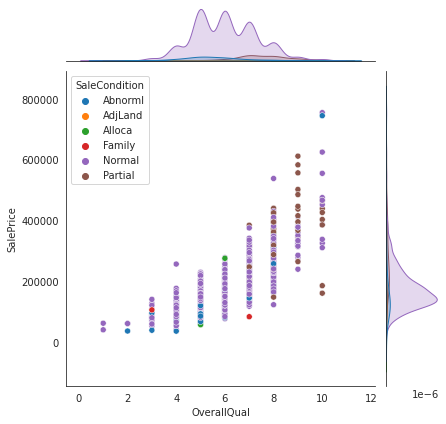

In [ ]:
sns.jointplot('OverallQual', 'SalePrice', train_dataset, hue='SaleCondition');

In [ ]:
quantitative_df = pd.melt(train_dataset, id_vars=['SalePrice'], value_vars=quantitative)

# create grids
grids = sns.FacetGrid(quantitative_df, col='variable', col_wrap=3, sharex=False, sharey=False, palette='light:b')
quantitaive_plot = grids.map(sns.regplot, 'value', 'SalePrice');

####Categorical Values

Fill missing values with `MISSING`

In [ ]:
for col in qualitative:
  train_dataset[col] = train_dataset[col].astype('category')
  test_dataset[col] = test_dataset[col].astype('category')
  if train_dataset[col].isnull().any():
    train_dataset[col] = train_dataset[col].cat.add_categories(['MISSING'])
    train_dataset[col] = train_dataset[col].fillna('MISSING') # fill all null val with 'MISSING'
  if test_dataset[col].isnull().any():
    test_dataset[col] = test_dataset[col].cat.add_categories(['MISSING'])
    test_dataset[col] = test_dataset[col].fillna('MISSING') # fill all null val with 'MISSING'

In [ ]:
# create a catergorical df where values or categorical
categorical_df = pd.melt(train_dataset, id_vars=['SalePrice'], value_vars=qualitative)

In [ ]:
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_dataset);

Categorical Columns Distribution with `SalePrice`

In [ ]:
grids = sns.FacetGrid(categorical_df, col="variable", col_wrap=3, sharex=False, sharey=False, margin_titles=True, height=5)
catergorical_plot = grids.map(sns.stripplot, "value", "SalePrice", color=".3")
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in catergorical_plot.axes.flat];

### Data Preparation for Training

Identify `features` columns and `targets` - `SalePrice` column

In [ ]:
# split train and test dataset into features and target columns
features_columns = train_dataset.drop(['SalePrice', 'Id'], axis=1).columns
target_column = 'SalePrice'
train_features = train_dataset[features_columns].copy(deep=True)
train_targets = train_dataset[target_column].copy()

test_features = test_dataset[features_columns].copy(deep=True)

There is several columns with null values. We'll drop columns with large number of nan values and use `SimpleImputer` from scikit-learn to handle missing values on the numerical columns

In [ ]:
train_features.drop(columns=['PoolQC', 'MiscFeature', 'Alley'], inplace=True)
test_features.drop(columns=['PoolQC', 'MiscFeature', 'Alley'], inplace=True)

In [ ]:
train_features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


Define `numerical` and `categorical` columns

In [ ]:
numerical_columns = train_features.select_dtypes(include=np.number).columns
categorical_columns = train_features.select_dtypes(exclude=np.number).columns

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
# apply imputer to fill missing value with mean values
train_features[numerical_columns] = SimpleImputer(strategy='mean').fit_transform(train_features[numerical_columns])
test_features[numerical_columns] = SimpleImputer(strategy='mean').fit_transform(test_features[numerical_columns])

Scalling `Numeric` Values with `MinMaxScaler` and `Encoding` `Categorical` data

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

In [ ]:
# fit and transform test and train numerical values into given range
train_features[numerical_columns] = MinMaxScaler().fit_transform(train_features[numerical_columns])
test_features[numerical_columns] = MinMaxScaler().fit_transform(test_features[numerical_columns])

In [ ]:
# handle the nan values and encoded all other categorical data
# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
encoder = OrdinalEncoder()
train_features[categorical_columns] = encoder.fit_transform(train_features[categorical_columns])
test_features[categorical_columns] = encoder.fit_transform(test_features[categorical_columns])

Creating an extra `Validation Set`

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_features, val_features, train_targets, val_targets = train_test_split(train_features, train_targets, test_size=0.2, random_state=42)

### Decision Tree

Building `DecisionTreeRegressor`

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

Using `GridSearchCV` to tune Hyperparameters

In [ ]:
DecisionTree = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=42), 
                            {'max_depth': [10, 20, 30, 35],
                             'max_features': [8, 10, 12, 15, 18]},
                            scoring='neg_mean_squared_error')

In [ ]:
%%time
TreeRegressors = DecisionTree.fit(train_features, train_targets)

Tuning Results: `cv_results_` represent a dict which store all results for different hyperparameters tested. Other attributes like `best_score_`, `best_params_` can be used to evaluate the best parameters

In [ ]:
# display results as pandas dataframe
cv_results = pd.DataFrame(TreeRegressors.cv_results_)

In [ ]:
best_params = TreeRegressors.best_params_
best_tree = TreeRegressors.best_estimator_

Calling predict on model with the best params

In [ ]:
val_pred = best_tree.predict(val_features)
val_pred[:10]

#### Model Evaluation

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
# compute the mse for training and validation set
mse_train = best_tree.score(train_features, train_targets)
mse_val = best_tree.score(val_features, val_targets)
print(f'Train MSE: {mse_train} / Validation MSE: {mse_val}')

NameError: ignored

In [ ]:
val_pred = best_tree.predict(val_features)
train_pred = best_tree.predict(train_features)

In [ ]:
val_r2Score = r2_score(val_pred, val_targets)
train_r2Score = r2_score(train_pred, train_targets)
print(f'Validation Set r2 score: {val_r2Score}, Training Set: {train_r2Score}')

Plotting `Learning Curve`

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(best_tree, train_features, train_targets, scoring='r2', return_times=True)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_sizes, np.mean(train_scores, axis=1))
plt.plot(train_sizes, np.mean(test_scores, axis=1))
plt.title('DecisionTreeRegression Model Learning Curve')
plt.ylabel('Score')
plt.xlabel('Data size')
plt.legend(['Train', 'Test']);

####Tree Visualization

In [ ]:
from sklearn.tree import plot_tree, export_text

In [ ]:
best_tree.tree.max_depth

`feature_importances_` attribute return the importance value of each feature which is used to predict the results

In [ ]:
feature_importances = pd.DataFrame({'features': train_features.columns,
                                    'importance': best_tree.feature_importances_}
                                   ).sort_values('importance', ascending=False).head(10) 

In [ ]:
sns.barplot(data=features_importance, x='importance', y='features', palette='pastel')

Number of `Garage Cars` and `Remodel date` are the most importance features with Decision Tree.

In [ ]:
plt.figure(figsize=(80,20))
visual_tree = plot_tree(best_tree, feature_names=train_features.columns, max_depth=3, filled=True);

In [ ]:
tree_text = export_text(best_tree, max_depth=5, feature_names=train_features.columns.to_list())

####**Gradient Boosting Tree**
Grandient Boosting Machine:
Training Decision Tree to reduce the loss and improve results from previous iteration

1. Use average of target column as initial input
2. The model is trained to compute the different between the previous predictions and target
3. Use learning rate to scale the prediction
4. Improved prediction will be obtained from the scaled prediction + previous prediction
5. Repeat step 2-5 

Using `xgboost` library to build Tree Boosting model

In [ ]:
from xgboost import XGBRegressor
from sklearn import cross_val_score

Hyperparameter tuning

In [ ]:
n_estimators = [100, 200, 300, 400, 500, 600]
results = {}
for n_estimator in n_estimators:
  xgb_tree = XGBRegressor(n_estimator=n_estimator)
  xgb_tree.fit(train_features, train_targets, 
               eval_set=[(train_features, train_targets), (test_features, test_targets)],
               eval_metric='r2')
  # get evaluation results dict
  evaluation_result = xgb_tree.evals_result()
  results[n_estimator] = {'train': (np.mean(evaluation_result['validation_0'])),
                          'val': (np.mean(evaluation_result['validation_1']))}


plt.plot(n_estimators, results[n_estimator]['train'] for n_estimator in n_estimators)
plt.plot(n_estimators, results[n_estimator]['val'] for n_estimator in n_estimators)
plt.title('R2 Score vs number of tree')
plt.legend(['Train', 'Validation']);

In [ ]:
xgb_tree = XGBRegressor(n_estimator=100, max_depth=9, randome_state=42, learning_rate=1e-2, n_jobs=-1)

In [ ]:
%%time
xgb_tree.fit(train_features, train_targets)

**Evaluation**

Using `K-fold` cross-validation methods

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [ ]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

# split the current train_features into train and validation set
for train_idx, val_idx in kfold.split(train_features):
  X_train, y_train = train_features.iloc[train_idx], train_targets.iloc[train_idx]
  X_val, y_val = train_features.iloc[val_idx], train_targets.iloc[val_idx]

  train_pred = xgb_tree.predict(X_train)
  val_pred = xgb_tree.predict(X_val)

  # compute cross validation score
  train_csv = cross_val_score(xgb_tree, X_train, y_train)
  val_csv = cross_val_score(xgb_tree, X_val, y_val)

  # compute r2 score
  train_r2 = r2_score(train_pred, train_targets)
  val_r2 = r2_score(val_pred, val_targets)

  
  print(f'Training r2 Score: {train_r2: >4f} / Test r2 Score: {val_r2: >4f}')
  print(f'Training Cross-Validation Score: {train_csv: >4f} / Validation-set Cross-Validation Score: {val_csv: >4f}')

**Visualization**

We can use `plot_tree` from `xgboost` to display tree graph or `dump` tree into text

In [ ]:
!pip install graphviz --upgrade --quiet
from xgboost import plot_tree

In [ ]:
tree_graph = plot_tree(xgb_tree, rankdir='LR', num_trees=10)

In [ ]:
tree_text = xgb_tree.get_booster().get_gump()
tree_text[0]

getting `features_importances_` score

In [ ]:
feature_importances_df = pd.DataFrame({'features': train_features.columns,
                              'importance': xgb_tree.feature_importances_}).sort_values('importance', ascending=False)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Hyperparameters Tuning with `GridSearchCV`

In [ ]:
Forest = GridSearchCV(RandomForestRegressor(n_estimators=150, criterion='mse'),
                             {'bootstrap': ['False', 'True'],
                              'n_jobs': [-1, None],
                              'max_depth' : [35, 30, 20],
                              'max_leaf_nodes': [2**5, 2**12],
                              'max_features': ['auto', 'log2', 'sqrt'],
                              'min_impurity_decrease': [1e-7, 1e-5, 1e-2]},
                              scoring='neg_mean_squared_error')

In [ ]:
%%time
RandomForest = Forest.fit(train_features, train_targets)

#### Random Forest Visualization

In [ ]:
pd.DataFrame({'features': train_features.columns,
              'importance': RandomForest.feature_importances_}).sort_values('importance').head()

In [ ]:
rf_mse_train = RandomForest.score(train_features, train_targets)
rf_mse_test = RandomForest.score(test_features, test_targets)

In [ ]:
rf_r2Score_train = r2_score(train_features, train_targets)
rf_r2Score_test = r2_score(test_features, test_targets)

#### Gradient Boosting Random Forest Model

In [ ]:
from xgboost import XGBRFRegressor
from sklearn import cross_val_score, r2_score

In [ ]:
xgb_rf = XGBRFRegressor(random_state=42, learning_rate=1e-2, max_depth=8, num_parallel_tree:500)

In [ ]:
xgb_rf.fit(train_features, train_targets)

In [ ]:
val_pred = xgb_rf.predict(val_features)

In [ ]:
val_csv = cross_val_score(xgb_rf, val_features, val_targets)
r2Score = r2_score(val_pred, val_targets)

### Making Prediction on `test_dataset`

In [ ]:
tree_pred = best_tree.predict(test_features)
forest_pred = RandomForest.predict(test_features)

### Saving Model

In [ ]:
import joblib

In [ ]:
jonlib.dump(model, 'model.joblib')